# Tensor Methods Homework 4

### 1 CPD approximation by ALS

Implement the alternating-least-squares (ALS) algorithm for the low-rank approximation of a tensor of dimension $d \in \N$ at least two and mode sizes $n_1, \dots, n_d \in \N$. For $R, r \in \N$ such that $r < R$, the implementation should take, as input parameters, a rank-$R$ CPD of the tensor given in the form of matrices $U_k \in \R^{n_k \times R}$ with $k ∈ \{1, \dots, d\}$ and a rank-$r$ CPD of the initial guess given in the form of matrices $V_k \in \R^{n_k \times r}$ with $k \in \{1, \dots, d\}$. The number of iterations to be performed should be an input parameter.

The best-accuracy rank-$r$ least-squares approximation problem is based on the cost function given by
$$ \phi(V_1, \dots, V_d) = \| \psi_r(V_1, \dots, V_d) − \psi_R(U_1, \dots, U_d)\|_F $$
for all $V_k \in \R^{n_k \times r}$ with $k \in \{1, \dots, d\}$, where $\psi_r$ and $\psi_R$ denote the CPD multilinear representation maps transforming CP decompositions of ranks $r$ and $R$ into tensors $\R^{n_1 \times \dots \times n_d}$.

In your implementation, a single ALS iteration starting at a CPD given by $V_k \in \R^{n_k \times r}$ with $k \in \{1, \dots, d\}$ should consists in updating $V_k$ for fixed $V_1, \dots, V_{k−1}, V_{k+1}, \dots, V_d$ with a solution of the optimization problem
$$ \phi(V_1, \dots, V_d) \to \min_{V_k \in \R^{n_k \times r}} $$
sequentially for $k = 1, 2, . . . , d − 1, d, d − 1, d − 2, . . . , 3, 2$.

An additional requirement is as follows: the cost of a single iteration should be linear with respect to $d$ (certain elementwise products of Gram matrices accumulating from the left and from the right should be stored, and exactly one of these should be updated at each step of a single iteration).

Make sure that your implementation evaluates the above cost function $\phi$, the 2-norm of $\nabla \frac{1}{2} \phi^2$ and the 2-norms of the $r$ CPD terms after each iteration and returns the history of the computed values alongside the final CP appproximation.

In [80]:
using LinearAlgebra
using Plots
using Printf

In [2]:
const CPD{T} = Vector{Matrix{T}} where T<:Number

function shape(A::CPD)
    shape = [size(U, 1) for U in A]
    return Tuple(shape)
end

function rank(A::CPD)
    ranks = [size(U, 2) for U in A]
    if isempty(ranks)
        return 0
    else
        @assert all(ranks .== ranks[1]) "Frame matrices do not share the same rank dimension."
        return ranks[1]
    end
end

# construct tensor from CPD factors
# from hw02 master solution
function CPDeval(A::CPD{T}) where T
    d = length(A)
    n = shape(A)
    r = rank(A)
    S = zeros(T, prod(n))

    for α = 1:r
        B = A[1][:,α]
        for k = 2:d
            B = kron(A[k][:,α], B)
        end
        S .+= B
    end
    reshape(S, n...)
end
;

In [3]:
function Khatri_Rao(A::AbstractMatrix{TA}, B::AbstractMatrix{TB}) where {TA, TB}
    m, k = size(A)
    n, kb = size(B)
    @assert k == kb "Column dimensions do not match: got $k and $kb."

    T = promote_type(TA, TB)
    C = similar(A, T, (m*n, k))

    for i = 1:k
        C[:,i] = kron(A[:,i], B[:,i])
    end
    return C
end
;

In [4]:
function unfold(A::AbstractArray, k::Integer)
    @assert 1 <= k <= ndims(A) "Given index out of bound: expected 1 ≤ k ≤ $(ndims(A))], got $k."
    n = size(A)
    p = prod(n[1:k-1])
    q = prod(n[k+1:end])
    Ak = reshape(A, p, n[k], q)
    Ak = permutedims(Ak, [2,1,3])
    Ak = reshape(Ak, n[k], p*q)
    return Ak
end
;

In [24]:
function ALS(A::CPD{TA}, X0::CPD{TX}, max_iter::Integer) where {TA, TX}
    d = length(A)
    n = shape(A)
    R = rank(A)
    r = rank(X0)
    T = promote_type(TA, TX)

    @assert (d == length(X0)) && all(n == shape(X0)) "Mode dimensions of initial guess do not match given tensor."
    @assert max_iter > 0 "Number of maximum iterations has to be greater than 0, got $max_iter."
    
    S = CPDeval(A)
    U = [unfold(S, k) for k = 1:d]
    X = copy(X0)
    errors = Vector{Float64}(undef, max_iter)
    
    for i = 1:max_iter
        
        # forward pass
        H_left = Matrix{T}(I, r, r)
        KR_left = ones(T, (1,r))
        for k = 1:d-1
            # Hadamard product of Gram matrices
            H_left = k==1 ? H_left : H_left .* (X[k-1]' * X[k-1])
            H_right = reduce((.*), [X[i]' * X[i] for i = (k+1):d])
            H = H_left .* H_right
            
            # Khatri-Rao product
            KR_left = k==1 ? KR_left : Khatri_Rao(KR_left, X[k-1])
            KR_right = reduce(Khatri_Rao, X[(k+1):d])
            KR = Khatri_Rao(KR_left, KR_right)

            # update frame matrix
            X[k] = U[k] * KR / H

            # normalize columns
            for j = 1:r
                X[k][:,j] /= norm(X[k][:,j])
            end
        end

        # backward pass
        H_right = Matrix{T}(I, r, r)
        KR_right = ones(T, (1,r))
        for k = d:-1:2
            # Hadamard product of Gram matrices
            H_left = reduce((.*), [X[i]' * X[i] for i = 1:(k-1)])
            H_right = k==d ? H_right : (X[k+1]' * X[k+1]) .* H_right
            H = H_left .* H_right
            
            # Khatri-Rao product
            KR_left = reduce(Khatri_Rao, X[1:(k-1)])
            KR_right = k==d ? KR_right : Khatri_Rao(X[k+1], KR_right)
            KR = Khatri_Rao(KR_left, KR_right)

            # update frame matrix
            X[k] = U[k] * KR / H

            # normalize columns
            for j = 1:r
                X[k][:,j] /= norm(X[k][:,j])
            end
        end
        
        errors[i] = norm(CPDeval(X) - S)
    end

    return X, errors
end
;

### 2 ALS approximation of the matrix-multiplication tensor

Consider the matrix-multiplication tensor ($d = 3$) for $n = 2$ and $r = 7$, $n = 3$ and $r = 23$, $n = 4$ and $r = 49$. For each $n \in \{2, 3, 4\}$, a CPD of rank $R = n^3$ is available (and was constructed in Assignment 2).

Test your implementation of the ALS algorithm on these three multiplication tensors with random initial guesses $V_1, V_2, V_3$, each matrix with all columns unitary (i.e. of norm one).

In [6]:
# construct matrix multiplication tensor CPD
# from hw02 master solution

function matmulTensorCPD(::Type{T}, n::Int) where T<:Number
    @assert n ≥ 2 "Dimension has to be greater than 2, got $n."

    U = zeros(T, n, n, n, n, n)
    V = zeros(T, n, n, n, n, n)
    W = zeros(T, n, n, n, n, n)

    for i ∈ 1:n, j ∈ 1:n, k ∈ 1:n
        U[i,k,i,j,k] = 1
        V[k,j,i,j,k] = 1
        W[i,j,i,j,k] = 1
    end

    U = reshape(U, n^2, n^3)
    V = reshape(V, n^2, n^3)
    W = reshape(W, n^2, n^3)

    return [U, V, W]
end
;

In [7]:
function randUnitaryColumns(m::Int, n::Int)
    V = rand(m, n)
    for j ∈ 1:n
        V[:,j] /= norm(V[:,j])
    end
    return V
end
;

In [10]:
function testMatmulTensor(n::Int, r::Int, runs::Int, max_iter::Int)
    d = 3
    M = matmulTensorCPD(Float64, n)
    plt = plot(
        title="ALS on matmul tensor for n=$n, rank=$r",
        xlabel="iterations",
        ylabel="error",
        xscale=:log10,
        yscale=:log10,
    )

    for _ ∈ 1:runs
        V = [randUnitaryColumns(n^2, n^3) for _ ∈ 1:d]
        _, errors = ALS(M, V, max_iter)
        plot!(1:max_iter, errors, label="", linealpha=0.5)
    end

    return plt
end
;

__a)__ Start with seven runs (seven different initial guesses) for $n = 2$. In this case, the algorithm can be expected to achieve the accuracy of $10^{−8}$ within 10000 iterations in at least one of the seven runs. Plot the error $\phi$ and the 2-norm of $\nabla \frac{1}{2} \phi^2$ at the end of each iteration with respect to the iteration count for several runs.

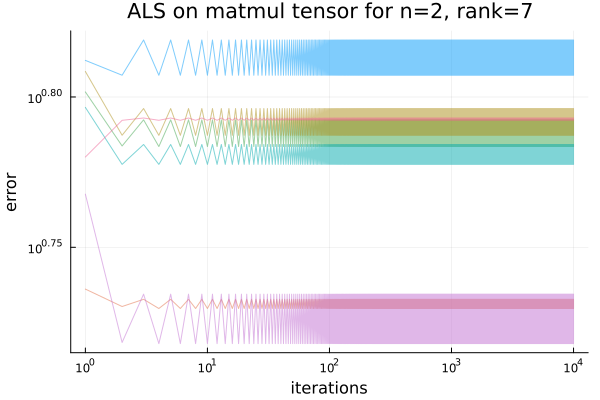

In [11]:
testMatmulTensor(2, 7, 7, 10000)

__b)__ Try repeating the experiment with $n = 3$ and $n = 4$. For each $n$, plot the error $\phi$ and the 2-norm of $\nabla \frac{1}{2} \phi^2$ at the end of each iteration with respect to the iteration count for several runs.

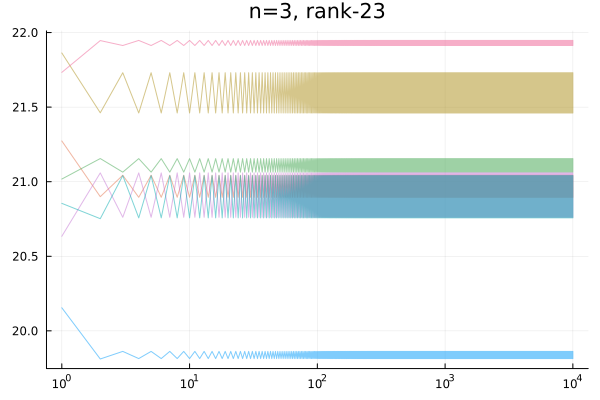

In [81]:
testMatmulTensor(3, 23, 7, 10000)

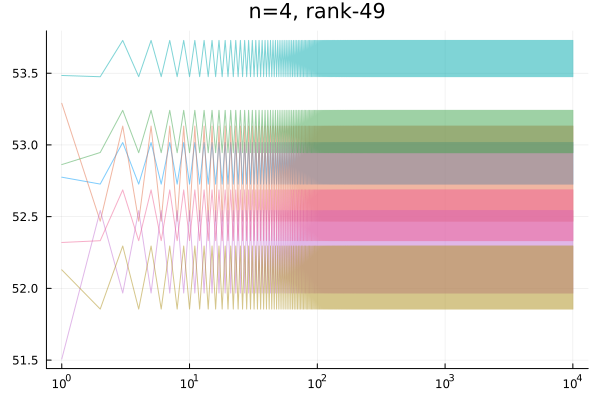

In [82]:
testMatmulTensor(4, 49, 7, 10000)

__c)__ From a rank-7 CPD of the tensor corresponding to $n = 2$, derive (analytically) a rank-49 CPD of the tensor corresponding to $n = 4$. Implement the construction of this CPD. Consider random perturbations of this CPD obtained by adding random perturbations to the entries of the CPD matrices drawn from the uniform distribution on $[−\varepsilon, \varepsilon]$. For $\varepsilon = 10^{−1}, \varepsilon = 10^{−2}, \dots, \varepsilon = 10^{−10}$, study the behavior of the ALS algorithm with the perturbed tensor used as an initial guess. For each $\varepsilon$, as above, plot the error $\phi$ and the 2-norm of $\nabla \frac{1}{2} \phi^2$ at the end of each iteration.

In [ ]:
# Strassen is rank 7
# consider n=4 as a block matrix of 2x2 matrices and get rank 7*7=49

In [75]:
d = 3
n = 4
r = 64
max_iter = 100
M4 = matmulTensorCPD(Float64, n)
εs = [10.0^(-d) for d = 1:10]

# from hw02 master solution
U = Matrix{Float64}([1 0 0 1 -1 0 -1; 0 0 0 -1 1 1 1; 0 1 0 1 0 0 0; 0 0 1 -1 0 1 1])
V = Matrix{Float64}([1 0 -1 0 0 -1 1; 0 1 1 0 0 0 0; 0 0 1 0 1 1 -1; 0 0 -1 1 -1 0 1])
W = Matrix{Float64}([1 1 0 0 0 0 0; 1 0 1 0 1 0 1; 1 0 0 1 0 1 1; 1 0 0 0 1 1 1])
M2 = [U, V, W]
;

In [76]:
T4 = M4 # TODO: construct from above
@show [size(U) for U in T4]
;

[size(U) for U = T4] = [(16, 64), (16, 64), (16, 64)]


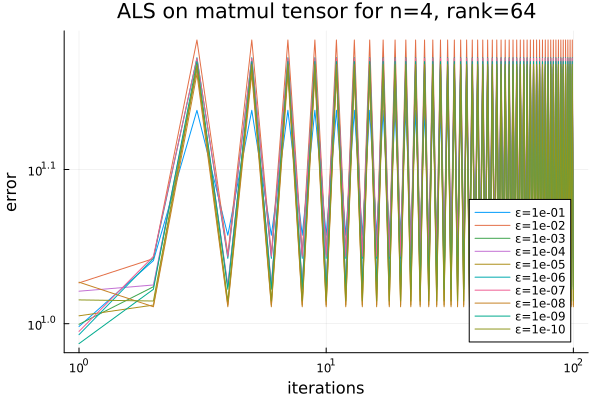

In [85]:
plt = plot(
    title="ALS on matmul tensor for n=$n, rank=$r",
    xlabel="iterations",
    ylabel="error",
    xscale=:log10,
    yscale=:log10,
)
for ε ∈ εs
    V = [T4[k] + (2*ε * rand(n^2, r) .- ε) for k ∈ 1:d]
    _, errors = ALS(M4, V, max_iter)
    plot!(1:max_iter, errors, label="ε=$(@sprintf("%.0e", ε))")
end
display(plt)

### 3 ALS approximation of a Laplace-like tensor

Consider the Laplace-like tensor ($d = 3$) from Problem 8 of Assignment 2:

$$ T = b \otimes a \otimes a + a \otimes b \otimes a + a \otimes a \otimes b \in \R^{2 \times 2 \times 2} $$

with $a = (1, 0)^\top \in \R^2$ and $b = (0, 1)^\top \in \R^2$. As we have established in Assignment 2, this tensor is of CP rank $R = 3$: the above definition is a rank-3 CPD, and the tensor has no rank-$r$ CPD with $r < 3$.

In [52]:
n = 2
r = 2
runs = 7
max_iter = 1000000

a = [1, 0]
b = [0, 1]
T = reshape(kron(b, a, a) + kron(a, b, a) + kron(a, a, b), n, n, n)
;

__a)__ Form a rank-3 CPD of $T$ and check that it is evaluated correctly as a 3-dimensional array (Problem 4 of Assignment 2 was on the implementation of the CPD evaluation).

In [53]:
U = [hcat(b, a, a), hcat(a, b, a), hcat(a, a, b)]
CPDeval(U) ≈ T

UndefVarError: UndefVarError: CPDeval not defined

__b)__ For each of seven random initial guesses, execute one million iterations of ALS approximation for $T$ with rank $r = 2$. For all the seven runs together, plot the approximation error vs. iteration count (i) for the first 100 iterations and (ii) for every 100th iteration. For all the seven runs together, plot the norm of the first CPD term of the approximation vs. the approximation error for every 100th iteration.

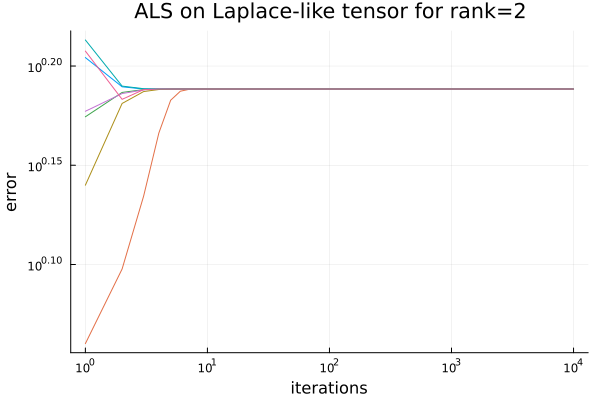

In [54]:
x = [1:99; 100:100:max_iter]
plt = plot(
    title="ALS on Laplace-like tensor for rank=$r",
    xlabel="iterations",
    ylabel="error",
    xscale=:log10,
    yscale=:log10,
)
for _ ∈ 1:runs
    V = [rand(n,r) for _ ∈ 1:3]
    _, errors = ALS(U, V, max_iter)
    plot!(x, errors[x], label="")
end
display(plt)